In [24]:
import sys
sys.path.insert(0,'/home/pawel1/Pulpit/Astrophysics/CTA/soft/ctapipe_io_lst')
sys.path.insert(0, '/home/pawel1/Pulpit/Astrophysics/CTA/cta-lstchain')

import matplotlib.pyplot as plt
import numpy as np
import h5py
from numba import njit, prange

from ctapipe_io_lst import LSTEventSource
from traitlets.config.loader import Config 
from ctapipe.image.extractor import LocalPeakWindowSum

from lstchain.calib.camera.r0 import LSTR0Corrections

from tools import get_first_capacitor
from time_cal_corr_all_camera import TimeCalCorr
from time_cal_corr import plot_corr_curve
plt.rcParams['font.size'] = 25

In [14]:
n_combine = 8
n_harm = 8
n_cap = 1024
n = int(n_cap/n_combine)
timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)

config_corr = Config({
    "LSTR0Corrections": {
        "pedestal_path": "/media/pawel1/ADATA HD330/20190215/pedestal_run97_new.fits",
        "offset":  400,
        "tel_id": 0, # for EVB3 will be 
    }
})

input_file_1 = "/media/pawel1/ADATA HD330/20190226/LST-1.*.Run00171.0000.fits.fz"
#input_file_1 = "/media/pawel1/ADATA HD330/20190312/LST-1.*.Run00250.0000.fits.fz"

In [15]:
reader = LSTEventSource(input_url=input_file_1, max_events=12000)
lst_r0 = LSTR0Corrections(config=config_corr)

timeCorr = TimeCalCorr(n_combine, n_harm, n_cap)


for i, ev in enumerate(reader):
    if ev.r0.event_id%500 == 0:
        print(ev.r0.event_id)
    lst_r0.calibrate(ev)
    timeCorr.calib_pulse_time(ev)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000


In [16]:
timeCorr.finalize()

/home/pawel1/Pulpit/Astrophysics/CTA/low_level_calib_drs4/time_corr/time_cal_corr_all_camera.py:47: RuntimeWarning: divide by zero encountered in true_divide
  self.fMeanVal = self.fMeanVal /self.fNumMean
/home/pawel1/Pulpit/Astrophysics/CTA/low_level_calib_drs4/time_corr/time_cal_corr_all_camera.py:47: RuntimeWarning: invalid value encountered in true_divide
  self.fMeanVal = self.fMeanVal /self.fNumMean


In [17]:
fan_array = np.zeros((1855, n_harm))
fbn_array = np.zeros((1855, n_harm))
for pix_id in range(0, 1855):
    timeCorr.fit(pix_id)
    fan_array[pix_id, :] = timeCorr.fan
    fbn_array[pix_id, :] = timeCorr.fbn

In [19]:
try:
    hf = h5py.File('coeff_run171_n_harm_8.h5', 'w')
    hf.create_dataset('fan', data=fan_array)
    hf.create_dataset('fbn', data=fbn_array)
    hf.attrs['n_harm'] = 8 
except Exception as err:
    print("FAILED!", err)

hf.close()

24
error = 0.03395933586855308


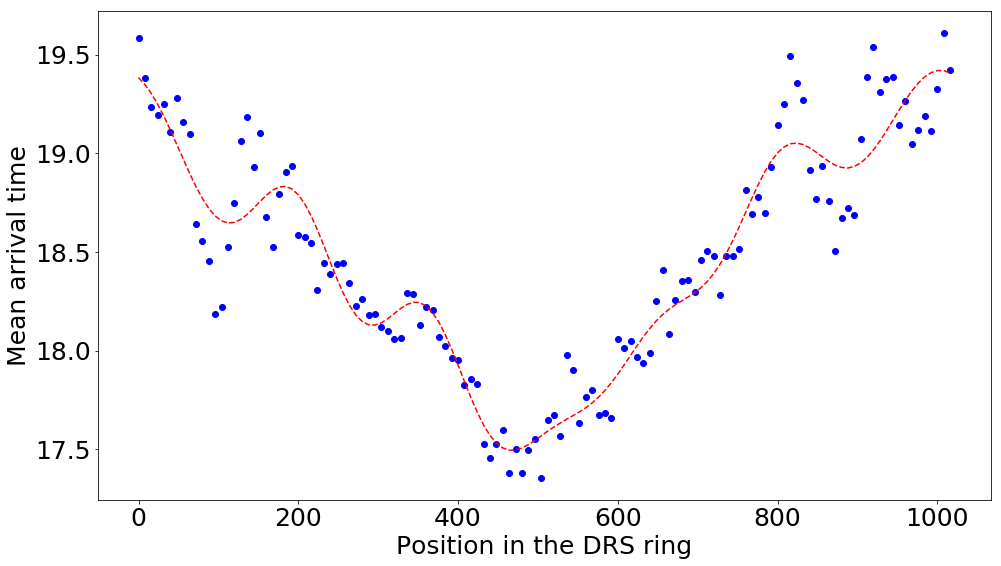

0
error = 0.04518531166992831


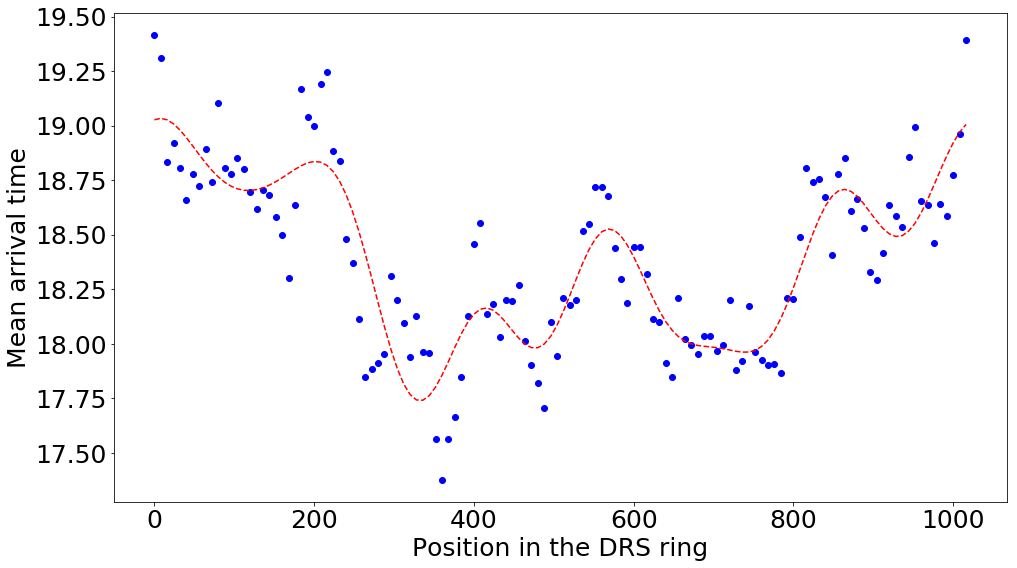

1
error = 0.02995734263647402


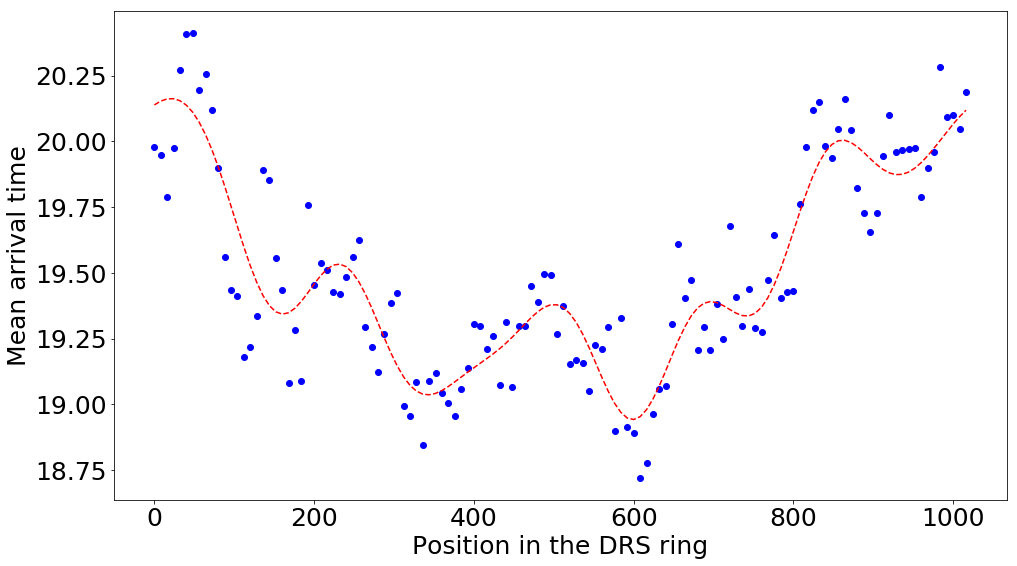

2
error = 0.04483143821935179


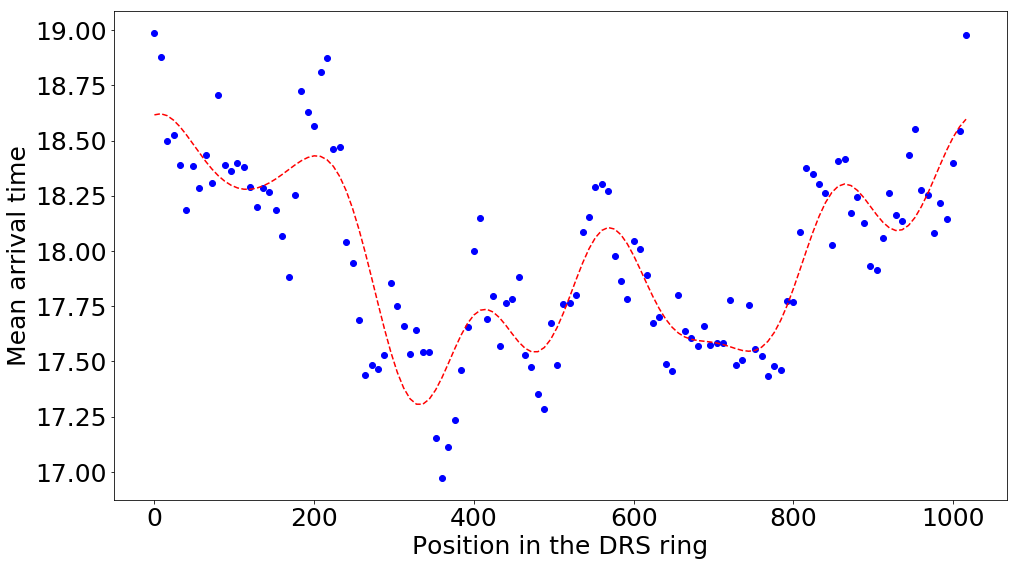

3
error = 0.03508022368617868


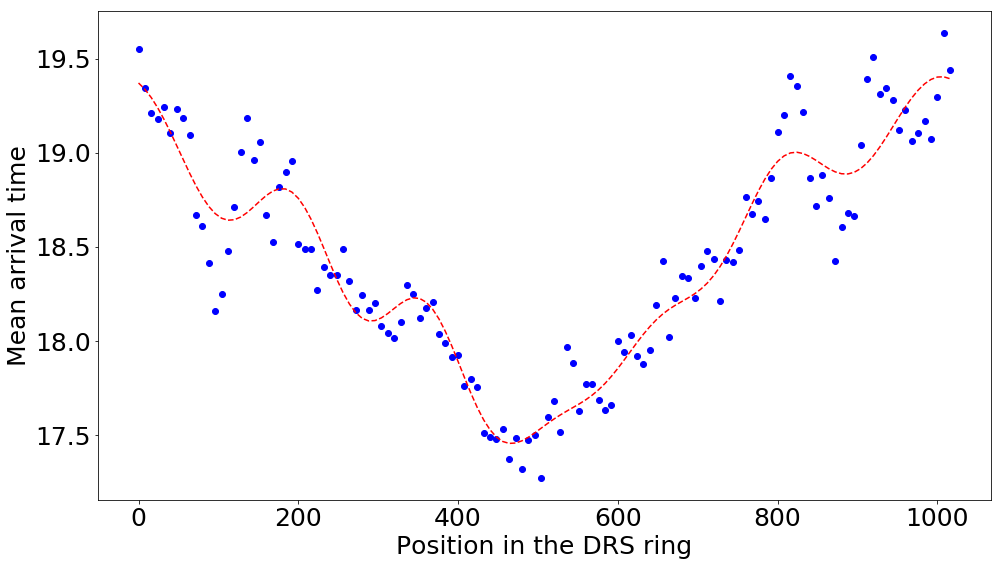

4
error = 0.049848617785349075


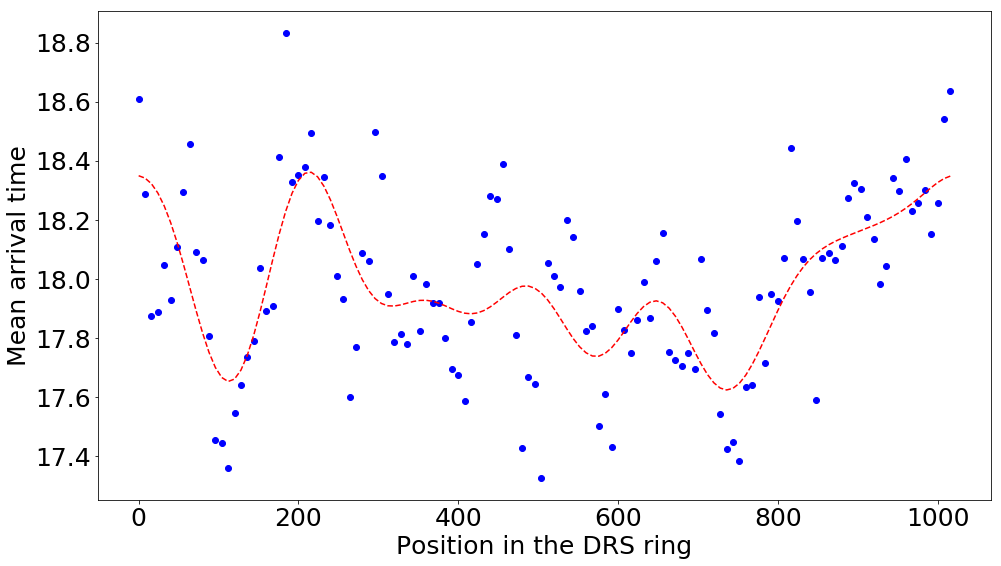

5
error = 0.048542212418504954


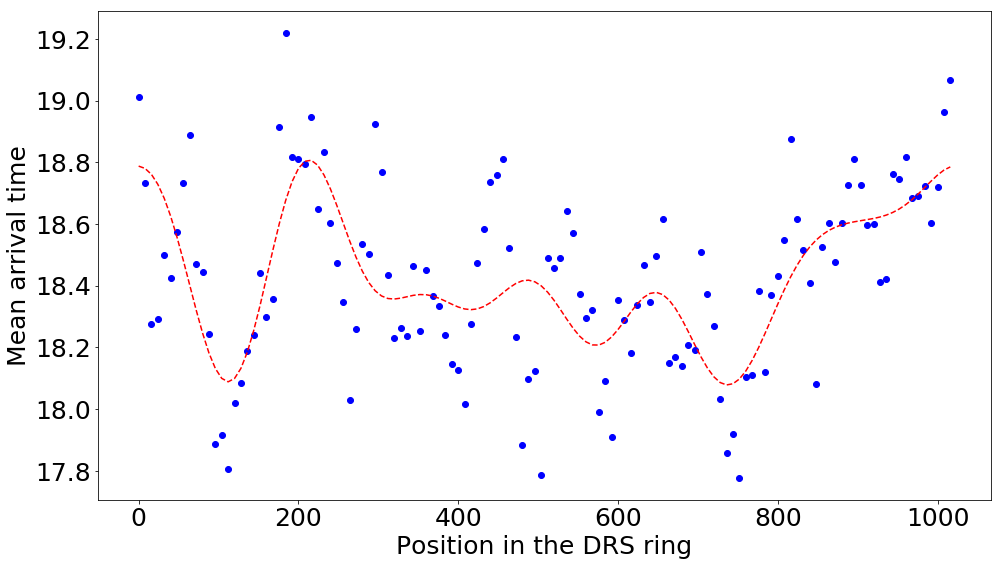

6
error = 0.029766011177082555


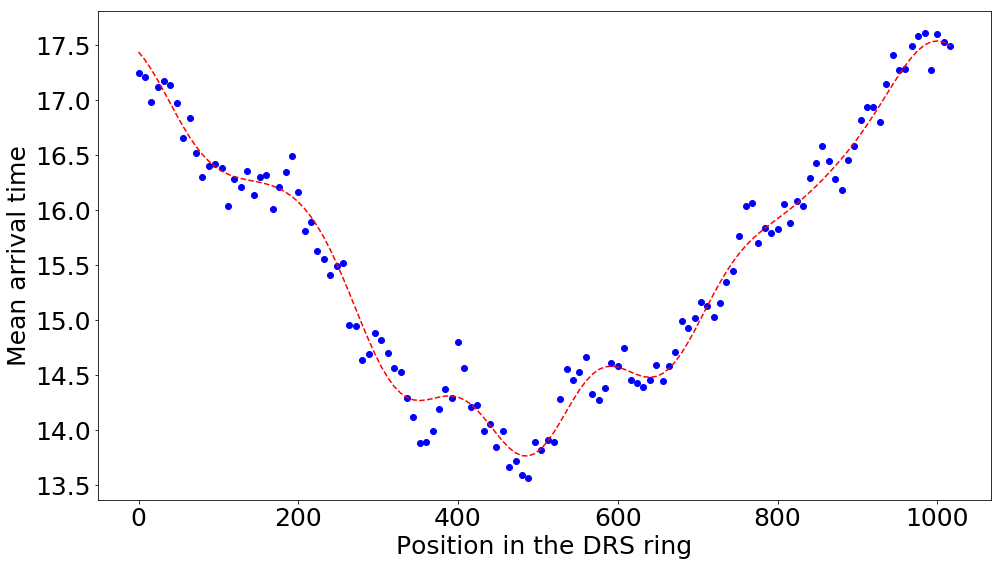

7
error = 0.0318073516326917


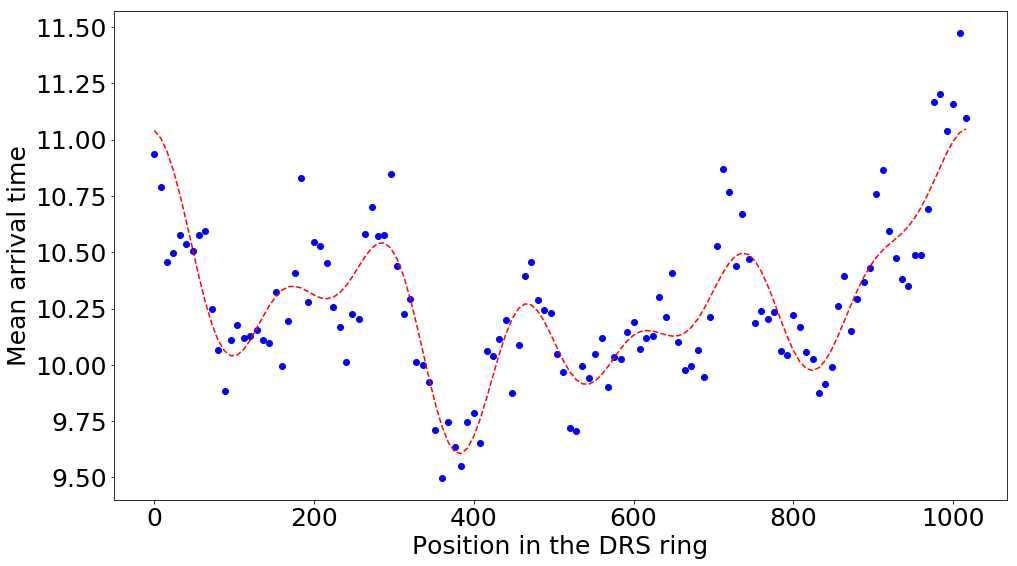

8
error = 0.046942626697437664


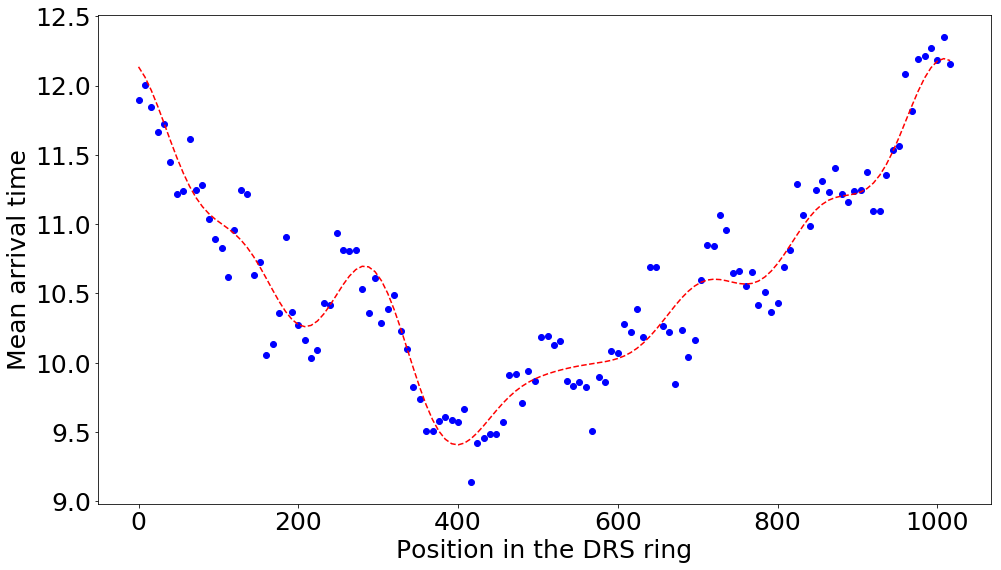

9
error = 0.0371487032178018


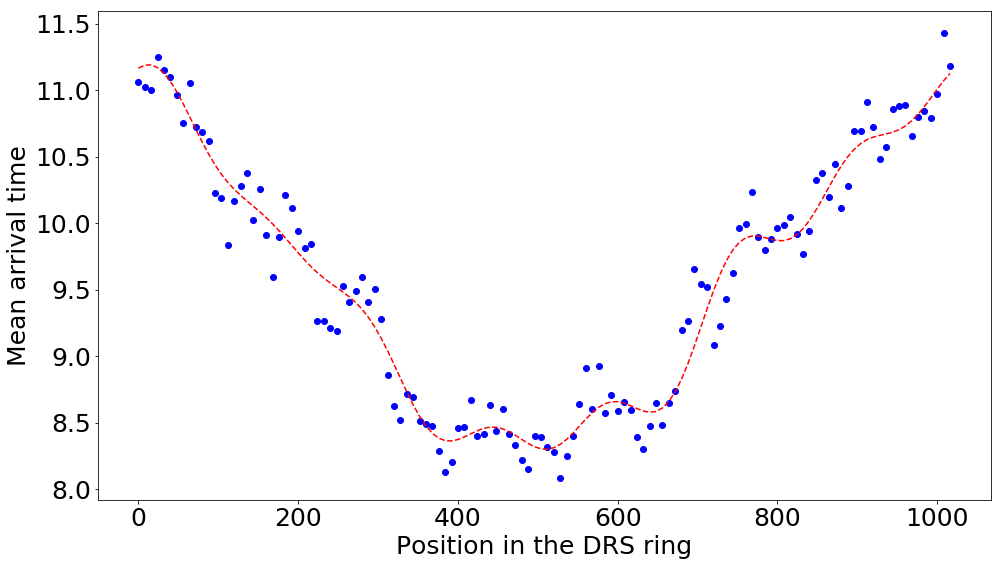

10
error = 0.037759896162209386


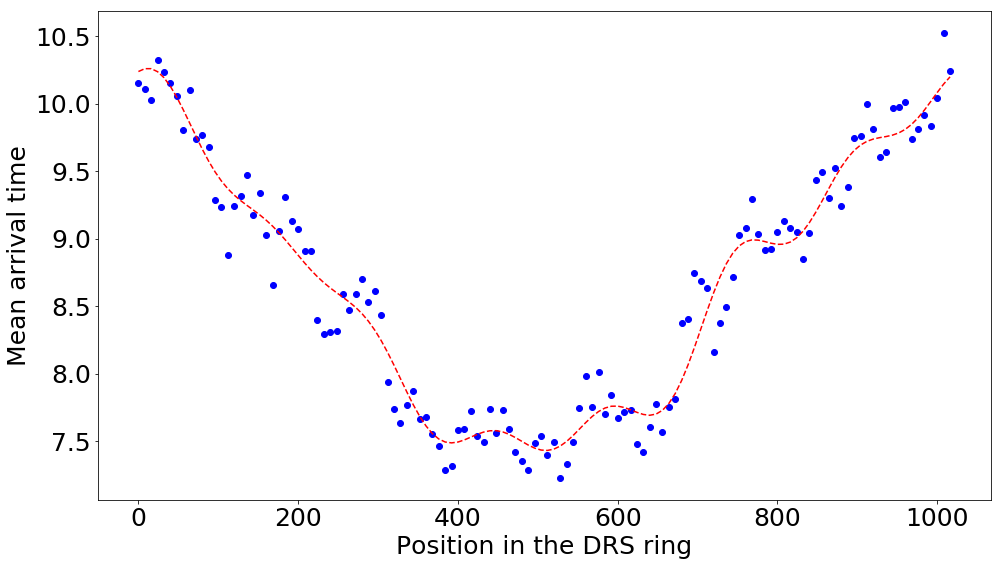

11
error = 0.03501575117463593


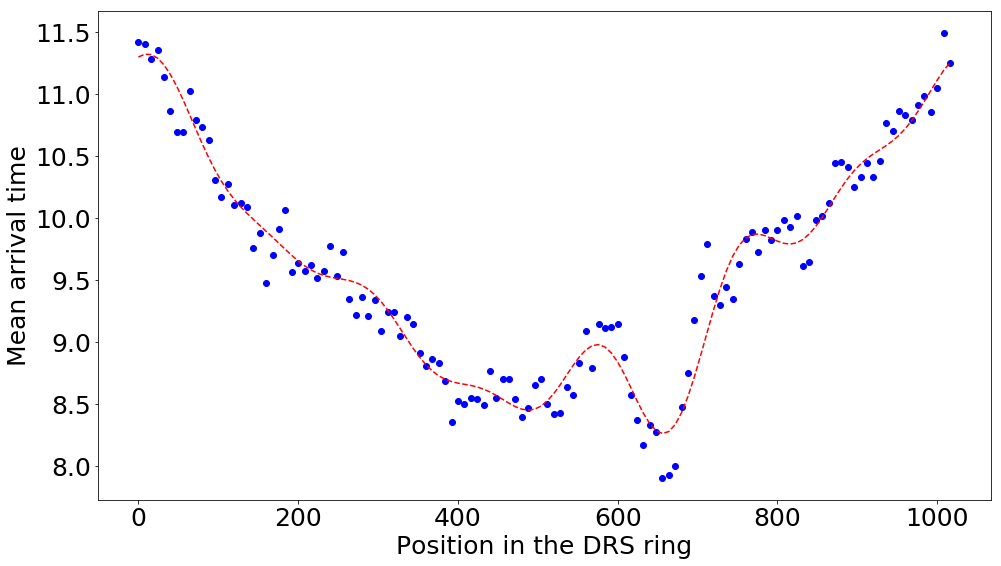

12
error = 0.04249437931166345


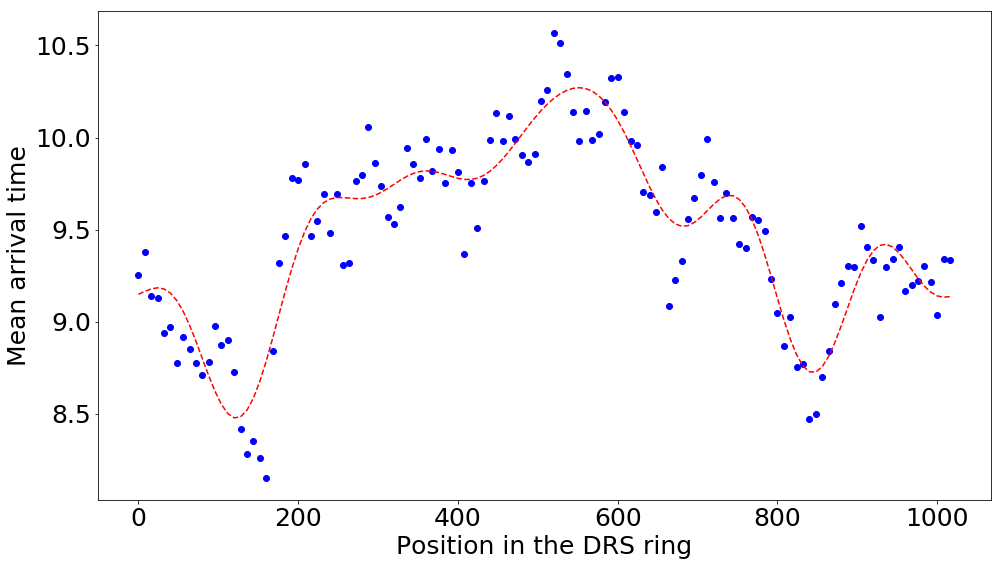

13
error = 0.038494944538977914


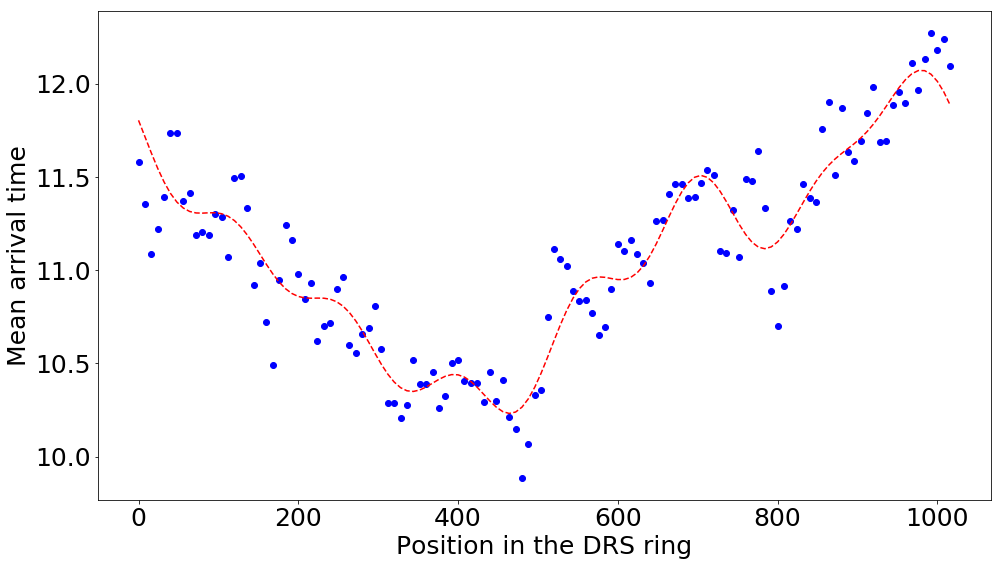

14
error = 0.03171738544698683


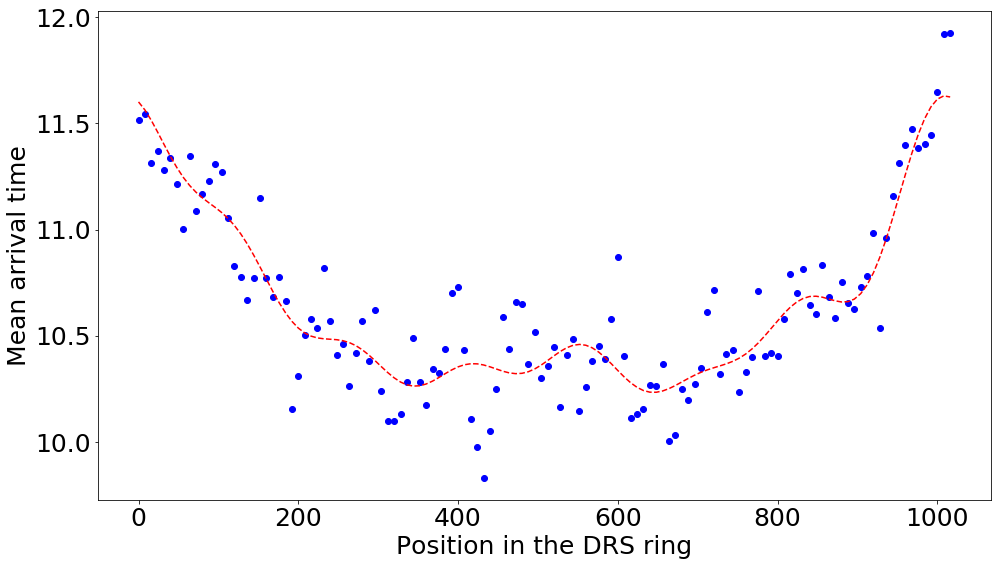

15
error = 0.03040017741757922


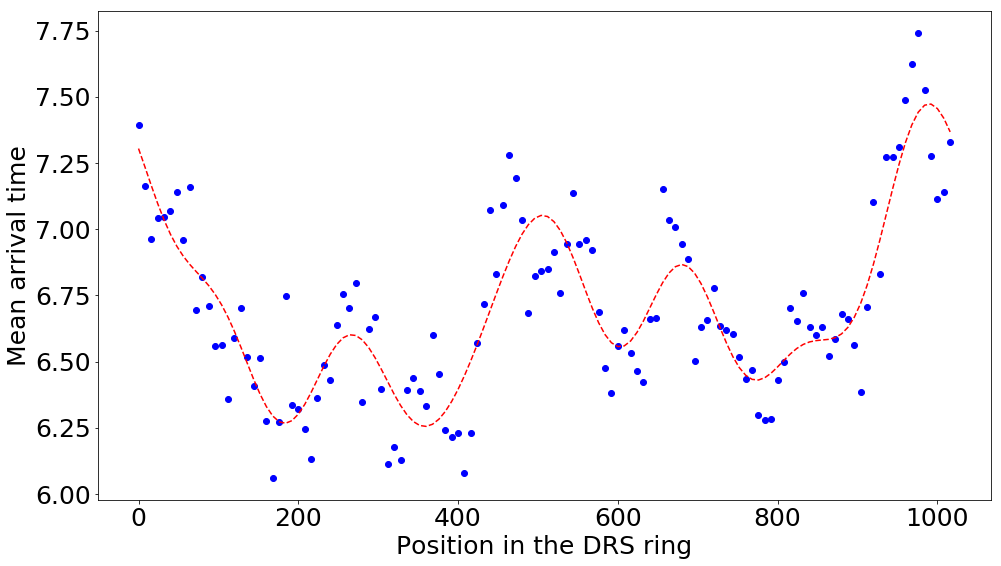

16
error = 0.02544530920383551


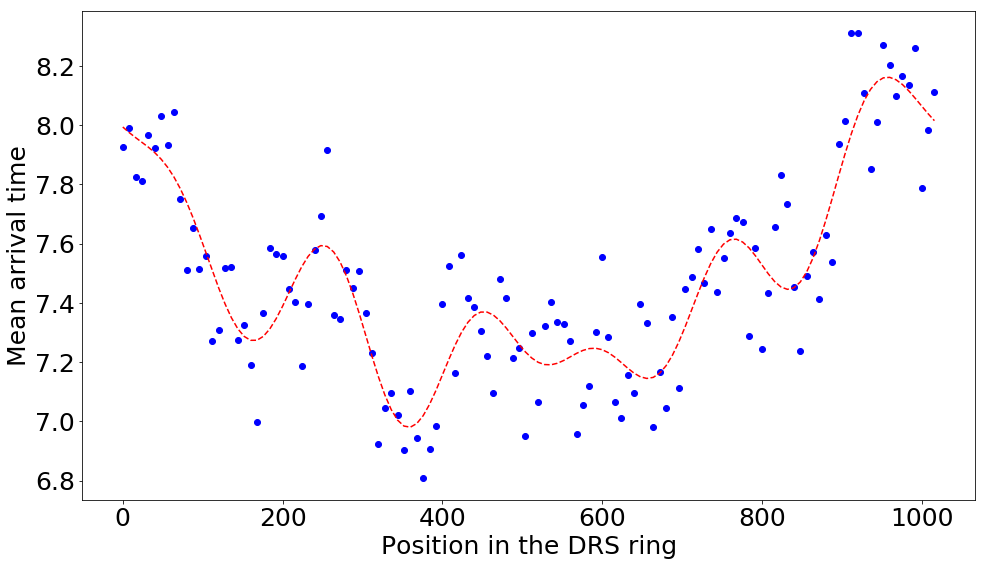

17
error = 0.03322535398180505


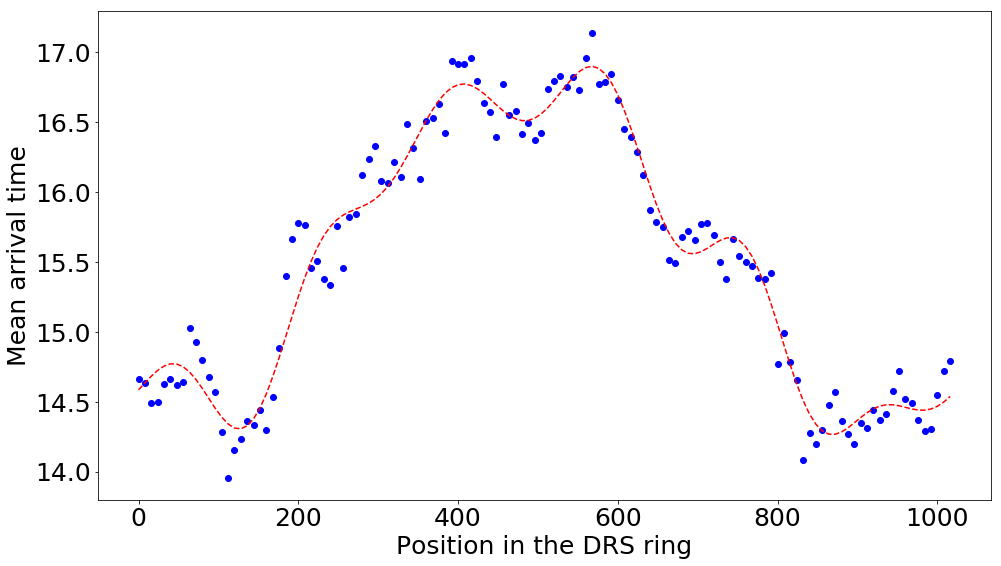

18
error = 0.03844380746251197


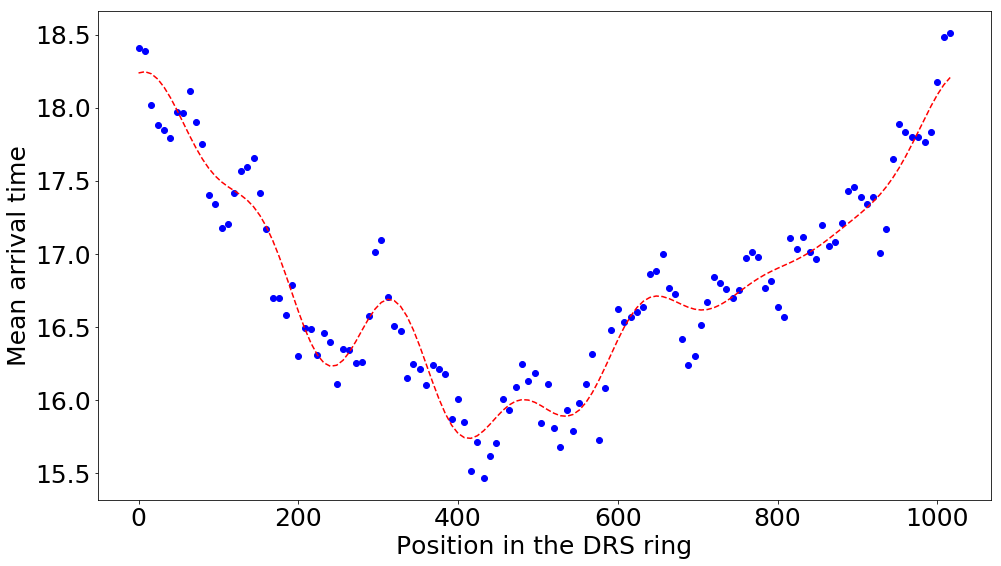

19
error = 0.030927855588214575


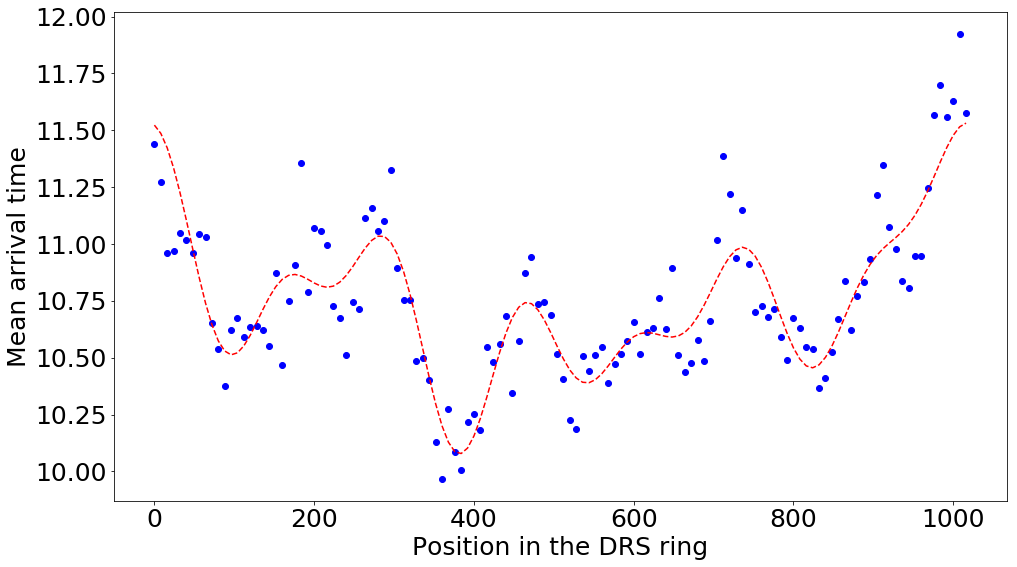

20
error = 0.045591815188922996


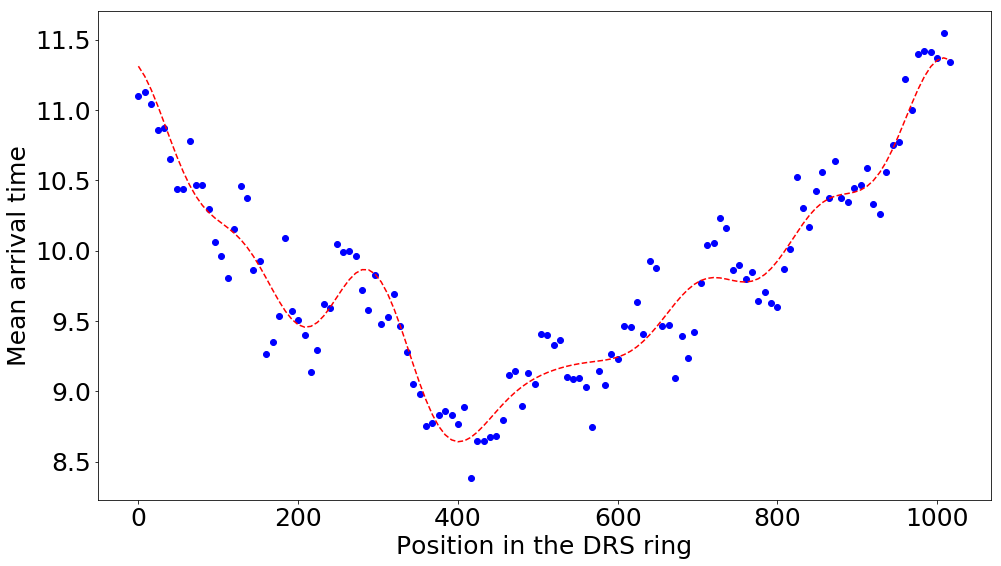

21
error = 0.06143121945938166


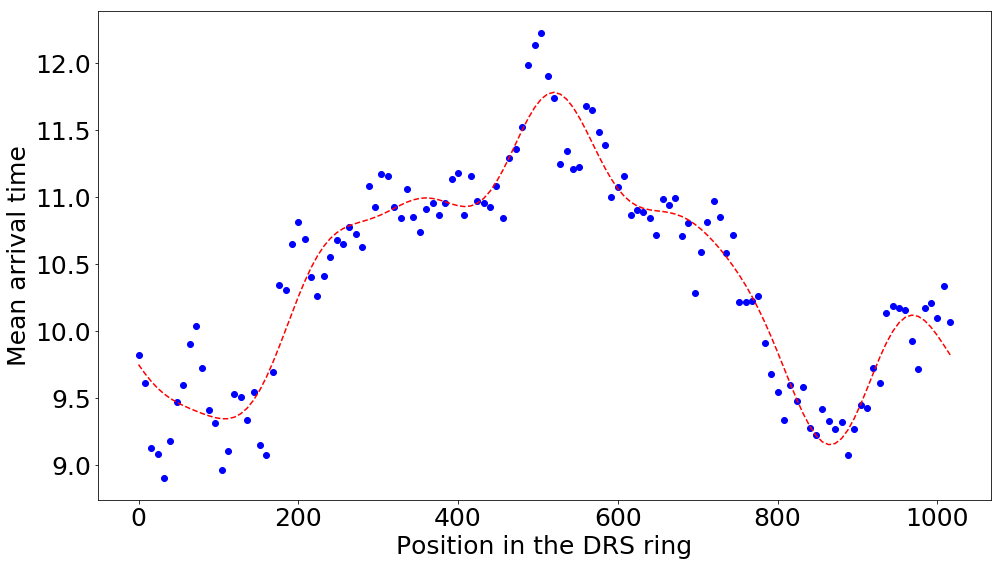

22
error = 0.022815117671431514


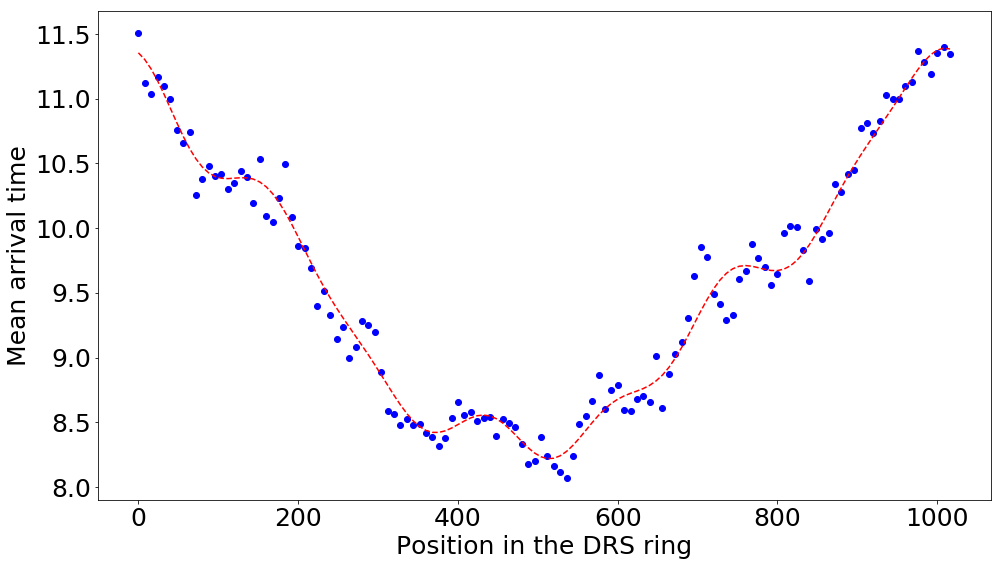

23
error = 0.03716874538596256


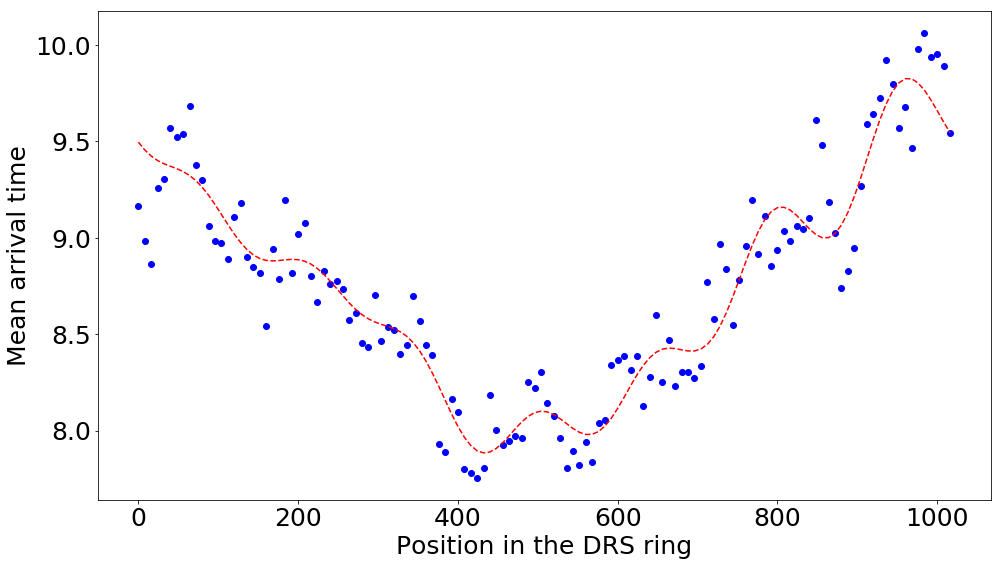

In [27]:
for pix_id in range(0, 25):
    print(pixel_id)
    pixel_id = pix_id
    timeCorr.fit(pix_id)
    an = timeCorr.fan
    bn = timeCorr.fbn
    fMeanVal = timeCorr.fMeanVal[pix_id]
    plot_corr_curve(n, n_cap, n_combine, an, bn, fMeanVal)
    if pix_id == 23:
        plt.savefig("fit_curve_pixel22.png")
    plt.show()